# PLANETOID - PubMed Dataset

This tutorial follows the one provided from https://github.com/pyg-team/pytorch_geometric/blob/master/examples/autoencoder.py

In [18]:
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GAE, VGAE, GCNConv
import torch
import matplotlib.pyplot as plt
%matplotlib inline

The PubMed dataset from Planetoid is a widely used benchmark for node classification tasks on graphs. Each node is a scientific paper while edges represent a citation relationship. Each node is represented as a bag-of-word feature vector and we should predict among the three classes:

Dataset Overview
- Type: Citation network
- Nodes: 19,717
- Edges: 44,338
- Node Features: 500-dimensional feature vectors
- Classes: 3

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

We can compose multiple transformation to the input data.
PyG offers also utils to perform splits and negative sampling

In [20]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])
dataset = Planetoid('./data', 'PubMed', transform=transform)
train_data, val_data, test_data = dataset[0]

In [21]:
train_data.x

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0554, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0114, 0.0047,  ..., 0.0000, 0.0000, 0.0000],
        [0.0531, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0145, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

We define the model

In [23]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

We can create the model using our custom encoder as input to the GAE model from PyG

In [24]:
in_channels, out_channels = dataset.num_features, 16
model = GAE(GCNEncoder(in_channels, out_channels))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

We define the training function for a single epoch and the test function.
Here the loss is computed by reconstructing the adjacency matrix, and the recon_loss function is defined in the GAE model from PyG, which also computes negative samples if not provided.

In [25]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)

In [26]:
epochs = 200
for epoch in range(1, epochs+1):
    loss = train()
    auc, ap = test(test_data)
    print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')

Epoch: 001, AUC: 0.9012, AP: 0.8837
Epoch: 002, AUC: 0.9005, AP: 0.8808
Epoch: 003, AUC: 0.8999, AP: 0.8795
Epoch: 004, AUC: 0.9000, AP: 0.8794
Epoch: 005, AUC: 0.9027, AP: 0.8823
Epoch: 006, AUC: 0.9043, AP: 0.8848
Epoch: 007, AUC: 0.9035, AP: 0.8858
Epoch: 008, AUC: 0.8997, AP: 0.8844
Epoch: 009, AUC: 0.8938, AP: 0.8810
Epoch: 010, AUC: 0.8877, AP: 0.8770
Epoch: 011, AUC: 0.8830, AP: 0.8738
Epoch: 012, AUC: 0.8797, AP: 0.8714
Epoch: 013, AUC: 0.8767, AP: 0.8693
Epoch: 014, AUC: 0.8724, AP: 0.8665
Epoch: 015, AUC: 0.8658, AP: 0.8619
Epoch: 016, AUC: 0.8570, AP: 0.8558
Epoch: 017, AUC: 0.8474, AP: 0.8490
Epoch: 018, AUC: 0.8396, AP: 0.8433
Epoch: 019, AUC: 0.8357, AP: 0.8403
Epoch: 020, AUC: 0.8363, AP: 0.8402
Epoch: 021, AUC: 0.8400, AP: 0.8423
Epoch: 022, AUC: 0.8457, AP: 0.8459
Epoch: 023, AUC: 0.8531, AP: 0.8509
Epoch: 024, AUC: 0.8629, AP: 0.8576
Epoch: 025, AUC: 0.8753, AP: 0.8670
Epoch: 026, AUC: 0.8890, AP: 0.8789
Epoch: 027, AUC: 0.9005, AP: 0.8911
Epoch: 028, AUC: 0.9066, AP:

In [27]:
model.eval()
with torch.no_grad():
    embeddings  = model.encode(test_data.x, test_data.edge_index)

test_embeddings = embeddings.cpu().numpy()
test_labels = test_data.y.cpu().numpy()

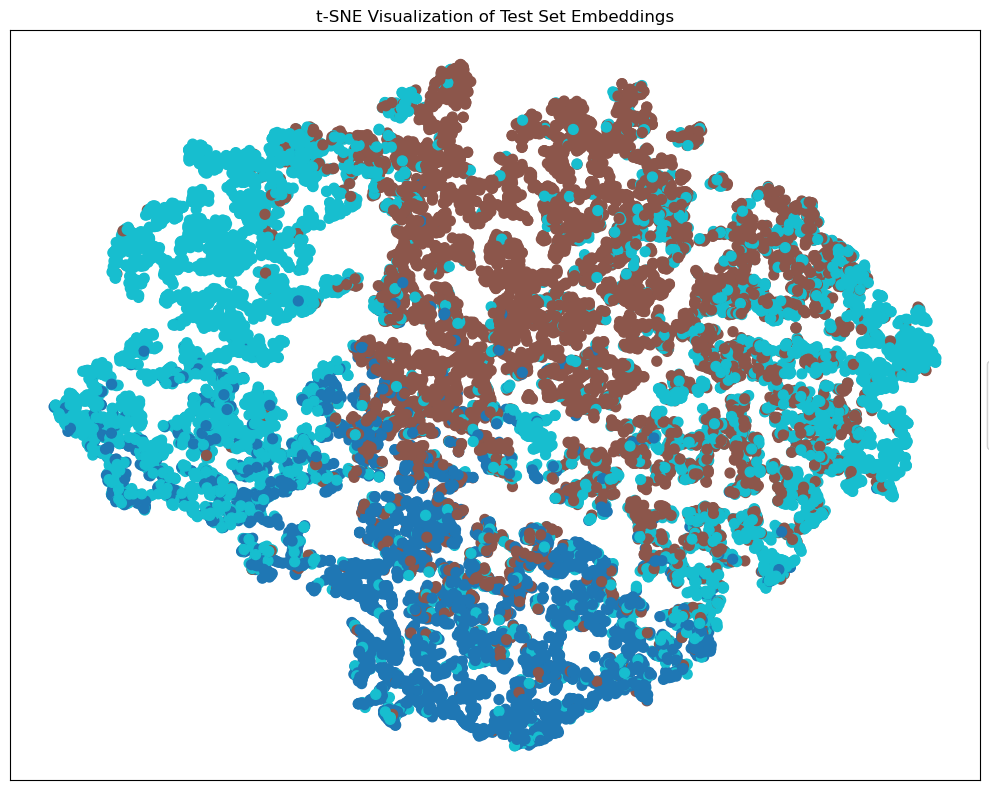

In [28]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(test_embeddings)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot t-SNE
scatter = ax.scatter(tsne_embeddings[:, 0], 
                    tsne_embeddings[:, 1],
                    c=test_labels,
                    cmap='tab10',
                    alpha=1,
                    s=50)

# Add legend
legend1 = ax.legend(*scatter.legend_elements(),
                   loc="center left",
                   title="Classes",
                   bbox_to_anchor=(1, 0.5))
ax.add_artist(legend1)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Add title
plt.title('t-SNE Visualization of Test Set Embeddings')
plt.tight_layout()

## Downstream tasks after the pre traininig

We could also use the whole dataset now that we train another model if we veryfied that GAE trained correctly. Using only test is just to show the procedure for convenience.

In [32]:
model.eval()
with torch.no_grad():
    embeddings  = model.encode(test_data.x, test_data.edge_index)

test_embeddings = embeddings.cpu().numpy()
test_labels = test_data.y.cpu().numpy()

We can train something like XGBoost to predict the classes given the embeddings

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [43]:
z = test_embeddings
y = test_labels  

# Train-test split
z_train, z_test, y_train, y_test = train_test_split(z, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    random_state=42
)
rf_model.fit(z_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(z_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8101
